Trying different things to see if I can help figure out why Cullan's combined PV catalog has different statistics than just mine.

In [1]:
import numpy as np

from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM

from scipy.stats import binned_statistic

import matplotlib.pyplot as plt

# Data

In [2]:
hdul = fits.open('/global/cfs/cdirs/desicollab/science/td/pv/tfgalaxies/Y1/DESI-DR1_TF_pv_cat_v10.fits')
tf_data = Table(hdul[1].data)
tf_header = hdul[0].header
hdul.close()


pv_data = Table.read('/global/cfs/cdirs/desi/science/td/pv/combinedpv/Y1/PV_clustering_data.fits')
tf_data_combined = pv_data[pv_data['FP_FLAG'] == 0]
fp_data_combined = pv_data[pv_data['FP_FLAG'] == 1]

In [3]:
dwarf_boolean = tf_data['DWARF']

In [4]:
# Include TF scatter in uncertainties
TF_sig = tf_header['SIG']

tf_data['MU_TF_ERR'] = np.sqrt(tf_data['MU_TF_ERR']**2 + TF_sig**2)
tf_data['LOGDIST_ERR'] = np.sqrt(tf_data['LOGDIST_ERR']**2 + (0.2*TF_sig)**2)

In [5]:
np.min(tf_data['LOGDIST_ERR'])

0.13289562762720403

## Compute $\eta$ Cullan's way

In [6]:
cosmo_Cullan = FlatLambdaCDM(H0=100.0,Om0=0.3151)

logdist_Cullan = np.log10(cosmo_Cullan.comoving_distance(tf_data['Z_DESI_CMB']).value) + np.log10(1 + tf_data['Z_DESI']) - 0.2*tf_data['MU_TF'] + 5

/tmp/ipykernel_551677/2280798315.py:3: RuntimeWarning: invalid value encountered in log10
  logdist_Cullan = np.log10(cosmo_Cullan.comoving_distance(tf_data['Z_DESI_CMB']).value) + np.log10(1 + tf_data['Z_DESI']) - 0.2*tf_data['MU_TF'] + 5


# Profile histogram function

In [7]:
def profile_histogram(x, y, xbins, yerr=None, weights=None, median=False, weighted=False):
    """Compute a profile histogram from scattered data.
    
    Parameters
    ----------
    x : list or ndarray
        Ordinates (independent variable).
    y : list or ndarray
        Coordinates (dependent variable).
    xbins : list or ndarray
        Bin edges for the independent variable.
    yerr : list or ndarray
        Uncertainties on the dependent variable. Assumed independent.
    weights : list or ndarray
        If not None (and weighted=True), will use this instead of yerr to weight 
        the summary statistics.
    median : bool
        If true, compute median as central value; else, the (weighted) mean.
    weighted : bool
        Weight the summary statistics, either by the uncertainty in y or the 
        provided weights.
        
    Returns
    -------
    N : ndarray
        Unweighted counts per bin.
    h : ndarray
        Summary statistic (mean or median) of independent variable per bin.
    e : ndarray
        Uncertainty on the summary statistic per bin.
    """
    
    N = binned_statistic(x, y, bins=xbins, statistic='count').statistic

    if weighted:
        if (yerr is None) and (weights is None):
            raise ValueError('need to define either yerr or weights if using weighted fit.')

        if weights is None:
            # weight based on yerr
            w = 1/yerr**2
        else:
            w = weights
        W, H, E = binned_statistic(x, [w, w*y, w*y**2], bins=xbins, statistic='sum').statistic
        h = H/W
        e = 1/np.sqrt(W)
    else:
        mean, mean2 = binned_statistic(x, [y, y**2], bins=xbins, statistic='mean').statistic
        h = mean
        e = np.sqrt((mean2 - mean**2) / (N - 1))

    if median:
        h = binned_statistic(x, y, bins=xbins, statistic='median').statistic
    
    return N, h, e

In [8]:
def weighted_avg_and_std(values, weights, axis=None):
    '''
    Cullan's function to compute the weighted average and standard deviation.
    '''
    average = np.average(values, weights=weights, axis=axis)
    average_err = np.std(values)*np.sqrt(np.sum((weights/np.sum(weights))**2))
    variance = np.average((values-average)**2, weights=weights, axis=axis)
    return (average, average_err, np.sqrt(variance))

# Different cosmologies?

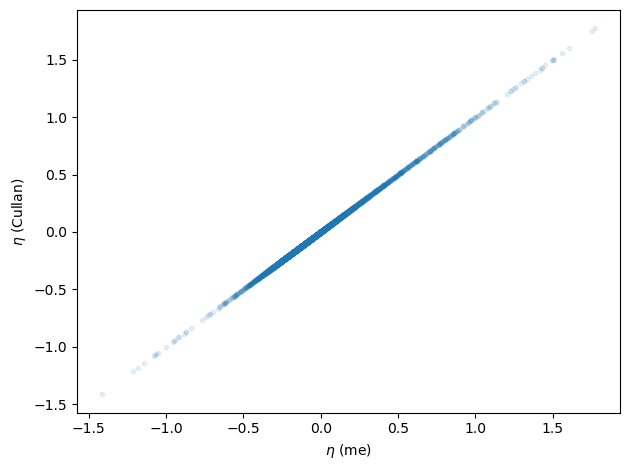

In [9]:
plt.figure(tight_layout=True)

plt.plot(tf_data['LOGDIST'][~dwarf_boolean], 
         logdist_Cullan[~dwarf_boolean], 
         '.', 
         alpha=0.1)

plt.xlabel('$\eta$ (me)')
plt.ylabel('$\eta$ (Cullan)');

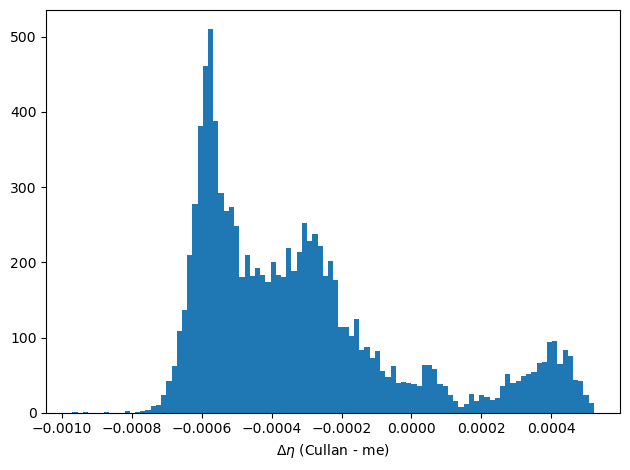

In [10]:
plt.figure(tight_layout=True)

plt.hist(logdist_Cullan[~dwarf_boolean] - tf_data['LOGDIST'][~dwarf_boolean], bins=100)

plt.xlabel(r'$\Delta \eta$ (Cullan - me)');

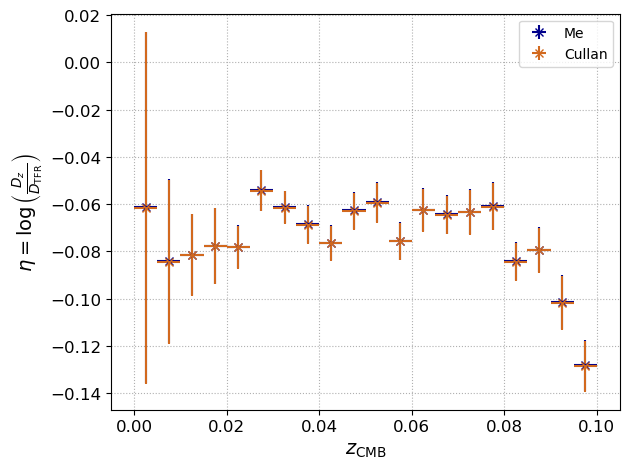

In [11]:
zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

sample1 = ~dwarf_boolean
sample2 = dwarf_boolean

plt.figure(tight_layout=True)

# Plot my median
N, y_avg, y_std = profile_histogram(tf_data['Z_DESI_CMB'][sample1], 
                                    tf_data['LOGDIST'][sample1], 
                                    zbins)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue', label='Me')

# Plot Cullan's median
N, y_avg, y_std = profile_histogram(tf_data['Z_DESI_CMB'][sample1], 
                                    logdist_Cullan[sample1], 
                                    zbins)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='chocolate', label='Cullan')

plt.grid(ls=':')

plt.legend()

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$z_{\text{CMB}}$', fontsize=14)
plt.ylabel(r'$\eta = \log \left( \frac{D_z}{D_{\text{TFR}}} \right)$', fontsize=14);

So the difference that we're seeing isn't due to different cosmologies.

# Different binning?

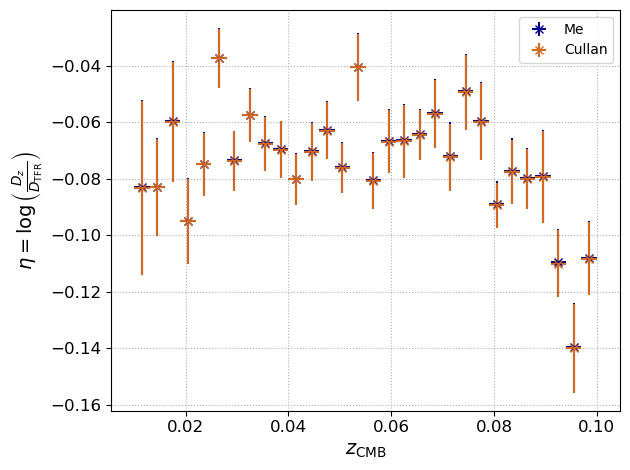

In [12]:
# Using Cullan's binning
nzbins = 31
zbins = np.linspace(0.01, 0.1, nzbins)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

sample1 = ~dwarf_boolean
sample2 = dwarf_boolean

plt.figure(tight_layout=True)

# Plot my median
N, y_avg, y_std = profile_histogram(tf_data['Z_DESI_CMB'][sample1], 
                                    tf_data['LOGDIST'][sample1], 
                                    zbins)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue', label='Me')

# Plot Cullan's median
N, y_avg, y_std = profile_histogram(tf_data['Z_DESI_CMB'][sample1], 
                                    logdist_Cullan[sample1], 
                                    zbins)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='chocolate', label='Cullan')

plt.grid(ls=':')

plt.legend()

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$z_{\text{CMB}}$', fontsize=14)
plt.ylabel(r'$\eta = \log \left( \frac{D_z}{D_{\text{TFR}}} \right)$', fontsize=14);

The difference isn't due to different binning.

# Different averaging?

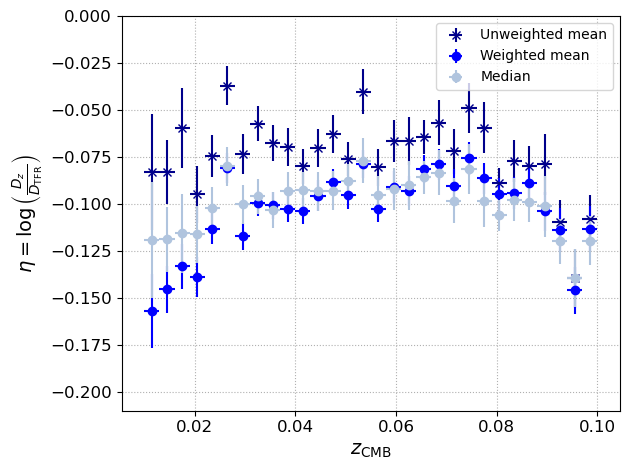

In [13]:
# Using Cullan's binning
nzbins = 31
zbins = np.linspace(0.01, 0.1, nzbins)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

sample1 = ~dwarf_boolean
sample2 = dwarf_boolean



plt.figure(tight_layout=True)

#-------------------------------------------------------------------------------
# Plot my mean (unweighted)
#-------------------------------------------------------------------------------
N, y_avg, y_std = profile_histogram(tf_data['Z_DESI_CMB'][sample1], 
                                    tf_data['LOGDIST'][sample1], 
                                    zbins)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue', label='Unweighted mean')
#-------------------------------------------------------------------------------
# Plot my mean (weighted)
#-------------------------------------------------------------------------------
N, y_avg, y_std = profile_histogram(tf_data['Z_DESI_CMB'][sample1], 
                                    tf_data['LOGDIST'][sample1], 
                                    zbins, 
                                    weights=1/tf_data['LOGDIST_ERR'][sample1]**2, 
                                    weighted=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='o', color='blue', label='Weighted mean')
#-------------------------------------------------------------------------------
# Plot my median
#-------------------------------------------------------------------------------
N, y_avg, y_std = profile_histogram(tf_data['Z_DESI_CMB'][sample1], 
                                    tf_data['LOGDIST'][sample1], 
                                    zbins, 
                                    median=True
                                    )
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='o', color='lightsteelblue', label='Median')
'''
#-------------------------------------------------------------------------------
# Plot my data with Cullan's averaging function
#-------------------------------------------------------------------------------
y_avg = np.zeros(nzbins-1)
y_avg_err = np.zeros(nzbins-1)
y_std = np.zeros(nzbins-1)

for i in range(nzbins-1):
    idx = sample1 & (tf_data['Z_DESI_CMB'] > zbins[i]) & (tf_data['Z_DESI_CMB'] <= zbins[i+1])
    y_avg[i], y_avg_err[i], y_std[i] = weighted_avg_and_std(tf_data['LOGDIST'][idx], 
                                                            1/tf_data['LOGDIST_ERR'][idx]**2)

plt.errorbar(zc, y_avg, xerr=dz, yerr=y_avg_err, fmt='x', color='chocolate', label='Cullan')

#-------------------------------------------------------------------------------
# Plot Cullan's median
#-------------------------------------------------------------------------------
N, y_avg, y_std = profile_histogram(tf_data['Z_DESI_CMB'][sample1], 
                                    logdist_Cullan[sample1], 
                                    zbins)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='chocolate', label='Cullan')
'''
#-------------------------------------------------------------------------------

plt.grid(ls=':')

plt.legend()

plt.ylim(-0.21, 0)

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$z_{\text{CMB}}$', fontsize=14)
plt.ylabel(r'$\eta = \log \left( \frac{D_z}{D_{\text{TFR}}} \right)$', fontsize=14);

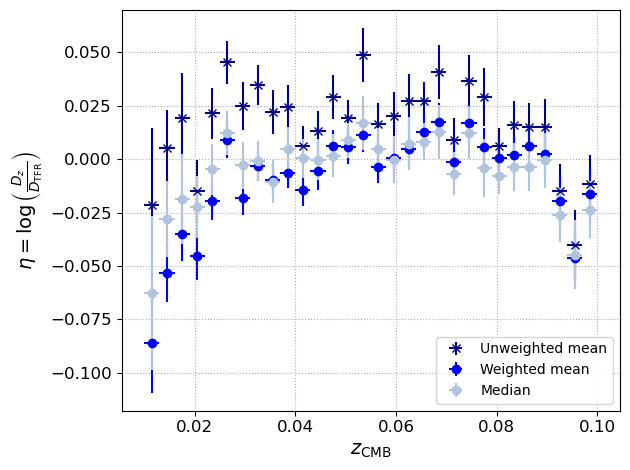

In [14]:
# Using Cullan's binning
nzbins = 31
zbins = np.linspace(0.01, 0.1, nzbins)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])



plt.figure(tight_layout=True)

#-------------------------------------------------------------------------------
# Plot my mean (unweighted)
#-------------------------------------------------------------------------------
N, y_avg, y_std = profile_histogram(tf_data_combined['ZCMB'], 
                                    tf_data_combined['LOGDIST'], 
                                    zbins)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue', label='Unweighted mean')
#-------------------------------------------------------------------------------
# Plot my mean (weighted)
#-------------------------------------------------------------------------------
N, y_avg, y_std = profile_histogram(tf_data_combined['ZCMB'], 
                                    tf_data_combined['LOGDIST'], 
                                    zbins, 
                                    weights=1/tf_data_combined['LOGDIST_ERR']**2, 
                                    weighted=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='o', color='blue', label='Weighted mean')
#-------------------------------------------------------------------------------
# Plot my median
#-------------------------------------------------------------------------------
N, y_avg, y_std = profile_histogram(tf_data_combined['ZCMB'], 
                                    tf_data_combined['LOGDIST'], 
                                    zbins, 
                                    median=True
                                    )
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='o', color='lightsteelblue', label='Median')
#-------------------------------------------------------------------------------

plt.grid(ls=':')

plt.legend()

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$z_{\text{CMB}}$', fontsize=14)
plt.ylabel(r'$\eta = \log \left( \frac{D_z}{D_{\text{TFR}}} \right)$', fontsize=14);

<Figure size 640x480 with 0 Axes>

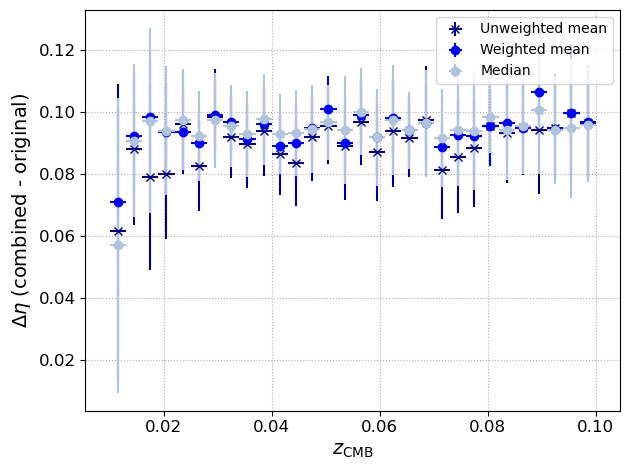

In [15]:
# Does the 0pt shift change as a function of redshift?

plt.figure(tight_layout=True)

# Using Cullan's binning
nzbins = 31
zbins = np.linspace(0.01, 0.1, nzbins)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])



plt.figure(tight_layout=True)

#-------------------------------------------------------------------------------
# Plot my mean (unweighted)
#-------------------------------------------------------------------------------
_, y_avg_original, y_std_original = profile_histogram(tf_data['Z_DESI_CMB'][sample1], 
                                    tf_data['LOGDIST'][sample1], 
                                    zbins)
_, y_avg_combined, y_std_combined = profile_histogram(tf_data_combined['ZCMB'], 
                                    tf_data_combined['LOGDIST'], 
                                    zbins)
plt.errorbar(zc, y_avg_combined - y_avg_original, 
             xerr=dz, 
             yerr=np.sqrt(y_std_original**2 + y_std_combined**2), 
             fmt='x', color='darkblue', 
             label='Unweighted mean')
#-------------------------------------------------------------------------------
# Plot my mean (weighted)
#-------------------------------------------------------------------------------
_, y_avg_original, y_std_original = profile_histogram(tf_data['Z_DESI_CMB'][sample1], 
                                    tf_data['LOGDIST'][sample1], 
                                    zbins, 
                                    weights=1/tf_data['LOGDIST_ERR'][sample1]**2, 
                                    weighted=True)
_, y_avg_combined, y_std_combined = profile_histogram(tf_data_combined['ZCMB'], 
                                    tf_data_combined['LOGDIST'], 
                                    zbins, 
                                    weights=1/tf_data_combined['LOGDIST_ERR']**2, 
                                    weighted=True)
plt.errorbar(zc, y_avg_combined - y_avg_original, 
             xerr=dz, 
             yerr=np.sqrt(y_std_original**2 + y_std_combined**2), 
             fmt='o', color='blue', 
             label='Weighted mean')
#-------------------------------------------------------------------------------
# Plot my median
#-------------------------------------------------------------------------------
_, y_avg_original, y_std_original = profile_histogram(tf_data['Z_DESI_CMB'][sample1], 
                                    tf_data['LOGDIST'][sample1], 
                                    zbins, 
                                    median=True
                                    )
_, y_avg_combined, y_std_combined = profile_histogram(tf_data_combined['ZCMB'], 
                                    tf_data_combined['LOGDIST'], 
                                    zbins, 
                                    median=True
                                    )
plt.errorbar(zc, y_avg_combined - y_avg_original, 
             xerr=dz, 
             yerr=np.sqrt(y_std_original**2 + y_std_combined**2), 
             fmt='o', color='lightsteelblue', 
             label='Median')
#-------------------------------------------------------------------------------

plt.grid(ls=':')

plt.legend()

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$z_{\text{CMB}}$', fontsize=14)
plt.ylabel(r'$\Delta \eta$ (combined - original)', fontsize=14);

# Correlation between uncertainty and redshift?

/tmp/ipykernel_551677/3818747994.py:50: RuntimeWarning: invalid value encountered in true_divide
  e = np.sqrt((mean2 - mean**2) / (N - 1))


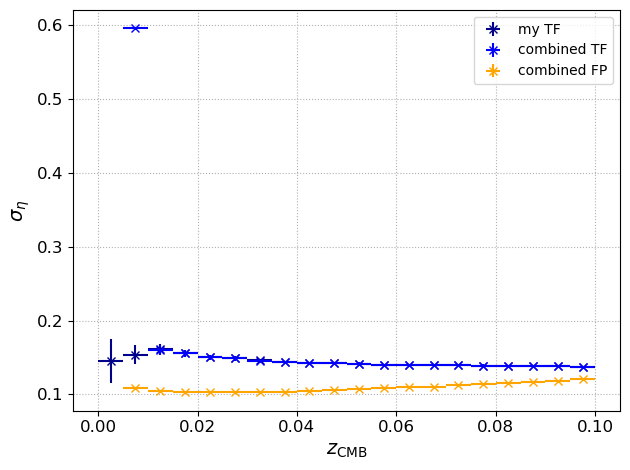

In [16]:
zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

sample1 = ~dwarf_boolean
sample2 = dwarf_boolean

plt.figure(tight_layout=True)

# Plot my median
N, y_avg, y_std = profile_histogram(tf_data['Z_DESI_CMB'][sample1], 
                                    tf_data['LOGDIST_ERR'][sample1], 
                                    zbins, 
                                    median=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue', label='my TF')

# Plot the combined catalog's TF
N, y_avg, y_std = profile_histogram(tf_data_combined['ZCMB'], 
                                    tf_data_combined['LOGDIST_ERR'], 
                                    zbins, 
                                    median=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='blue', label='combined TF')

# Plot the combined catalog's FP
N, y_avg, y_std = profile_histogram(fp_data_combined['ZCMB'], 
                                    fp_data_combined['LOGDIST_ERR'], 
                                    zbins, 
                                    median=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='orange', label='combined FP')

plt.grid(ls=':')

plt.legend()

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$z_{\text{CMB}}$', fontsize=14)
plt.ylabel(r'$\sigma_\eta$', fontsize=14);

/tmp/ipykernel_551677/3818747994.py:50: RuntimeWarning: invalid value encountered in true_divide
  e = np.sqrt((mean2 - mean**2) / (N - 1))


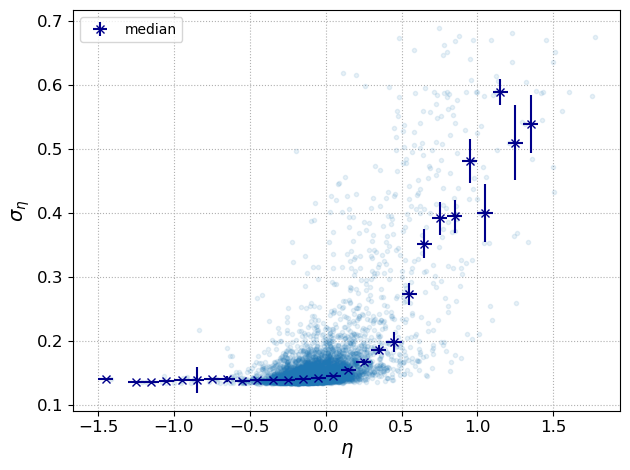

In [24]:
# Any correlation with eta?
nbins = np.arange(-1.5, 1.5, 0.1)
dn = 0.5*np.diff(nbins)
nc = 0.5*(nbins[1:] + nbins[:-1])

sample1 = ~dwarf_boolean
sample2 = dwarf_boolean

plt.figure(tight_layout=True)

plt.plot(tf_data['LOGDIST'][sample1], 
         tf_data['LOGDIST_ERR'][sample1], 
         '.', alpha=0.1)

# Plot my median
N, y_avg, y_std = profile_histogram(tf_data['LOGDIST'][sample1], 
                                    tf_data['LOGDIST_ERR'][sample1], 
                                    nbins, 
                                    median=True)
plt.errorbar(nc, y_avg, xerr=dn, yerr=y_std, fmt='x', color='darkblue', label='median')

plt.grid(ls=':')

plt.legend()

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$\eta$', fontsize=14)
plt.ylabel(r'$\sigma_\eta$', fontsize=14);

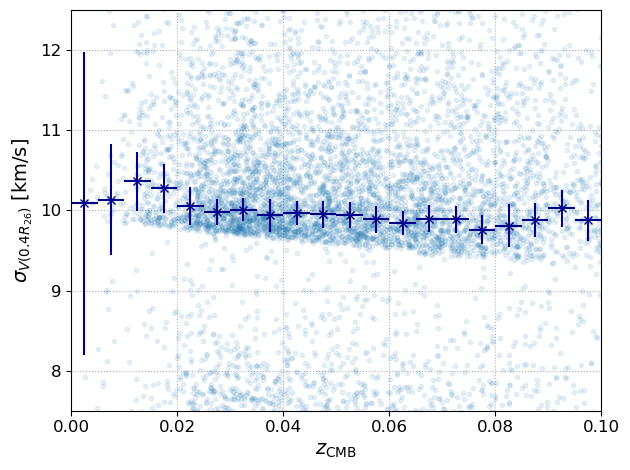

In [17]:
zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

sample1 = ~dwarf_boolean
sample2 = dwarf_boolean

plt.figure(tight_layout=True)

plt.plot(tf_data['Z_DESI_CMB'][sample1], tf_data['V_0p4R26_ERR'][sample1], '.', alpha=0.1)

# Plot my median
N, y_avg, y_std = profile_histogram(tf_data['Z_DESI_CMB'][sample1], 
                                    tf_data['V_0p4R26_ERR'][sample1], 
                                    zbins, 
                                    median=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue')

plt.grid(ls=':')

plt.xlim(0, 0.1)
plt.ylim(7.5, 12.5)

# plt.yscale('log')

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$z_{\text{CMB}}$', fontsize=14)
plt.ylabel(r'$\sigma_{V(0.4R_{26})}$ [km/s]', fontsize=14);

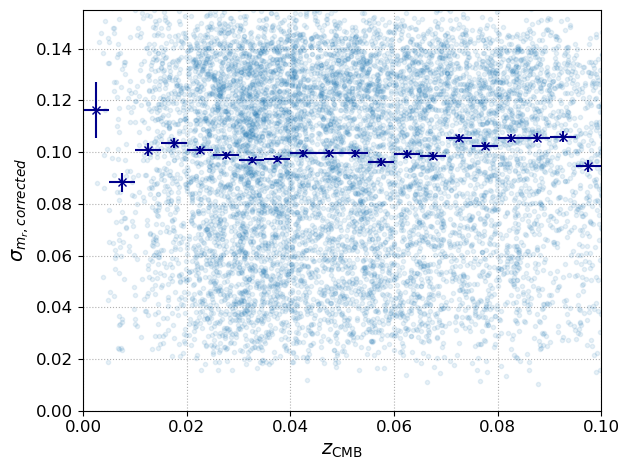

In [18]:
zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

sample1 = ~dwarf_boolean
sample2 = dwarf_boolean

plt.figure(tight_layout=True)

plt.plot(tf_data['Z_DESI_CMB'][sample1], tf_data['R_MAG_SB26_ERR_CORR'][sample1], '.', alpha=0.1)

# Plot my median
N, y_avg, y_std = profile_histogram(tf_data['Z_DESI_CMB'][sample1], 
                                    tf_data['R_MAG_SB26_ERR_CORR'][sample1], 
                                    zbins, 
                                    median=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue')

plt.grid(ls=':')

plt.xlim(0, 0.1)
plt.ylim(0, 0.155)

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$z_{\text{CMB}}$', fontsize=14)
plt.ylabel(r'$\sigma_{m_r, corrected}$', fontsize=14);

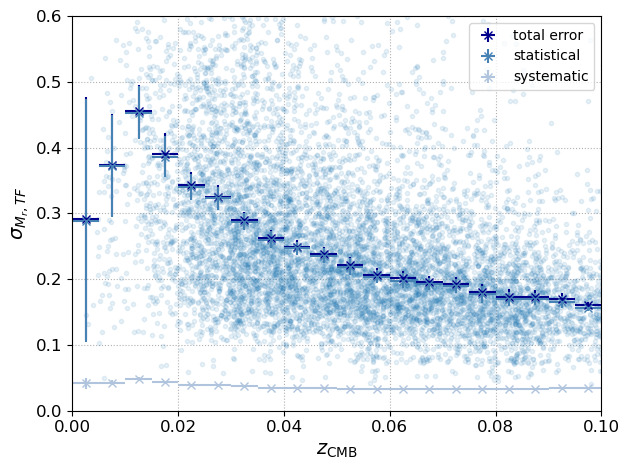

In [25]:
zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

sample1 = ~dwarf_boolean
sample2 = dwarf_boolean

plt.figure(tight_layout=True)

plt.plot(tf_data['Z_DESI_CMB'][sample1], tf_data['R_ABSMAG_SB26_TF_ERR'][sample1], '.', alpha=0.1)

# Total uncertainty
N, y_avg, y_std = profile_histogram(tf_data['Z_DESI_CMB'][sample1], 
                                    tf_data['R_ABSMAG_SB26_TF_ERR'][sample1], 
                                    zbins, 
                                    median=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue', label='total error')

# Statistical uncertainty (just from velocity uncertainty)
N, y_avg, y_std = profile_histogram(tf_data['Z_DESI_CMB'][sample1], 
                                    tf_data['R_ABSMAG_SB26_TF_ERR_STAT'][sample1], 
                                    zbins, 
                                    median=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='steelblue', label='statistical')

# Systematic uncertainty (from TF calibration)
N, y_avg, y_std = profile_histogram(tf_data['Z_DESI_CMB'][sample1], 
                                    tf_data['R_ABSMAG_SB26_TF_ERR_SYS'][sample1], 
                                    zbins, 
                                    median=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='lightsteelblue', label='systematic')

plt.grid(ls=':')

plt.legend()

plt.xlim(0, 0.1)
plt.ylim(0, 0.6)

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$z_{\text{CMB}}$', fontsize=14)
plt.ylabel(r'$\sigma_{M_r, TF}$', fontsize=14);

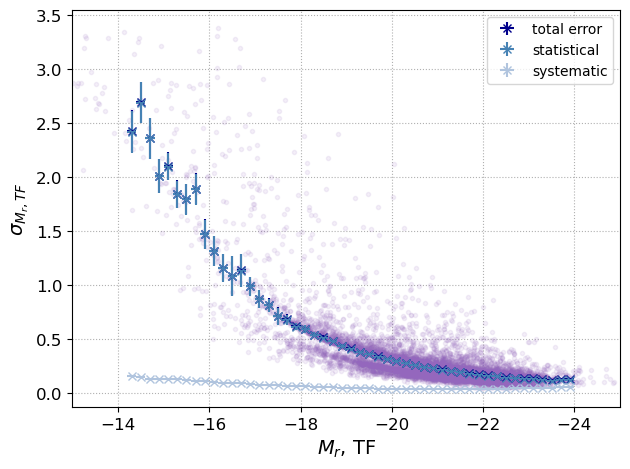

In [30]:
Mrbins = np.arange(-24, -14, 0.2)
dMr = 0.5*np.diff(Mrbins)
Mrc = 0.5*(Mrbins[1:] + Mrbins[:-1])

sample1 = ~dwarf_boolean
sample2 = dwarf_boolean

plt.figure(tight_layout=True)

plt.plot(tf_data['R_ABSMAG_SB26_TF'][sample1], 
         tf_data['R_ABSMAG_SB26_TF_ERR'][sample1], 
         '.', alpha=0.1, 
         c='tab:purple')

# Total uncertainty
N, y_avg, y_std = profile_histogram(tf_data['R_ABSMAG_SB26_TF'][sample1], 
                                    tf_data['R_ABSMAG_SB26_TF_ERR'][sample1], 
                                    Mrbins, 
                                    median=True)
plt.errorbar(Mrc, y_avg, xerr=dMr, yerr=y_std, fmt='x', color='darkblue', label='total error')

# Statistical uncertainty (just from velocity uncertainty)
N, y_avg, y_std = profile_histogram(tf_data['R_ABSMAG_SB26_TF'][sample1], 
                                    tf_data['R_ABSMAG_SB26_TF_ERR_STAT'][sample1], 
                                    Mrbins, 
                                    median=True)
plt.errorbar(Mrc, y_avg, xerr=dMr, yerr=y_std, fmt='x', color='steelblue', label='statistical')

# Systematic uncertainty (from TF calibration)
N, y_avg, y_std = profile_histogram(tf_data['R_ABSMAG_SB26_TF'][sample1], 
                                    tf_data['R_ABSMAG_SB26_TF_ERR_SYS'][sample1], 
                                    Mrbins, 
                                    median=True)
plt.errorbar(Mrc, y_avg, xerr=dMr, yerr=y_std, fmt='x', color='lightsteelblue', label='systematic')

plt.grid(ls=':')

plt.legend()

plt.xlim(-13, -25)
# plt.ylim(0, 0.6)

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$M_r$, TF', fontsize=14)
plt.ylabel(r'$\sigma_{M_r, TF}$', fontsize=14);

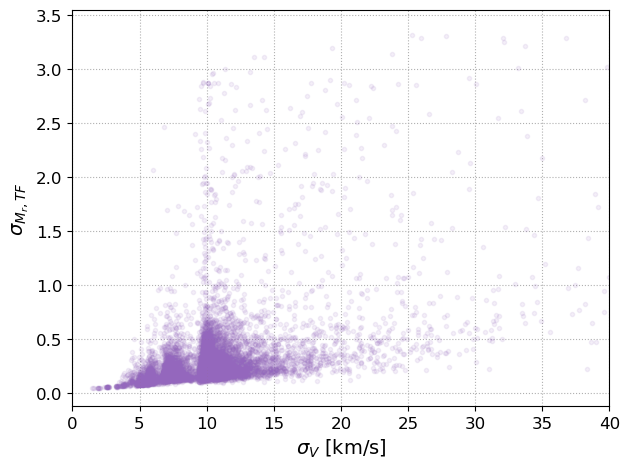

In [34]:
sigVbins = np.arange(5, 12, 0.2)
dsigV = 0.5*np.diff(sigVbins)
sigVc = 0.5*(sigVbins[1:] + sigVbins[:-1])

sample1 = ~dwarf_boolean
sample2 = dwarf_boolean

plt.figure(tight_layout=True)

plt.plot(tf_data['V_0p4R26_ERR'][sample1], 
         tf_data['R_ABSMAG_SB26_TF_ERR'][sample1], 
         '.', alpha=0.1, 
         c='tab:purple')
'''
# Total uncertainty
N, y_avg, y_std = profile_histogram(tf_data['R_ABSMAG_SB26_TF'][sample1], 
                                    tf_data['R_ABSMAG_SB26_TF_ERR'][sample1], 
                                    Mrbins, 
                                    median=True)
plt.errorbar(Mrc, y_avg, xerr=dMr, yerr=y_std, fmt='x', color='darkblue', label='total error')

# Statistical uncertainty (just from velocity uncertainty)
N, y_avg, y_std = profile_histogram(tf_data['R_ABSMAG_SB26_TF'][sample1], 
                                    tf_data['R_ABSMAG_SB26_TF_ERR_STAT'][sample1], 
                                    Mrbins, 
                                    median=True)
plt.errorbar(Mrc, y_avg, xerr=dMr, yerr=y_std, fmt='x', color='steelblue', label='statistical')

# Systematic uncertainty (from TF calibration)
N, y_avg, y_std = profile_histogram(tf_data['R_ABSMAG_SB26_TF'][sample1], 
                                    tf_data['R_ABSMAG_SB26_TF_ERR_SYS'][sample1], 
                                    Mrbins, 
                                    median=True)
plt.errorbar(Mrc, y_avg, xerr=dMr, yerr=y_std, fmt='x', color='lightsteelblue', label='systematic')
'''
plt.grid(ls=':')

# plt.legend()

plt.xlim(0, 40)
# plt.ylim(0, 0.6)

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$\sigma_V$ [km/s]', fontsize=14)
plt.ylabel(r'$\sigma_{M_r, TF}$', fontsize=14);